Обработка и анализ данных

Train shape: (90570, 4)
Test shape:  (9430, 4)
Число уникальных пользователей (train): 943
Число уникальных фильмов (train): 1680


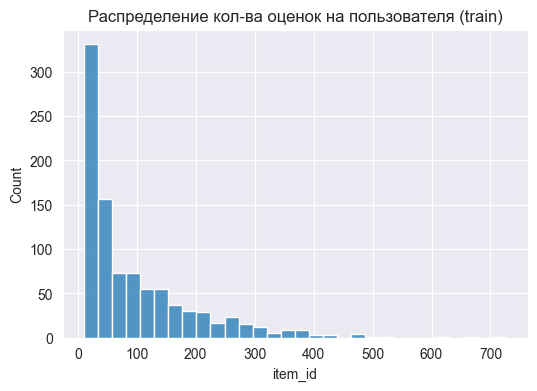

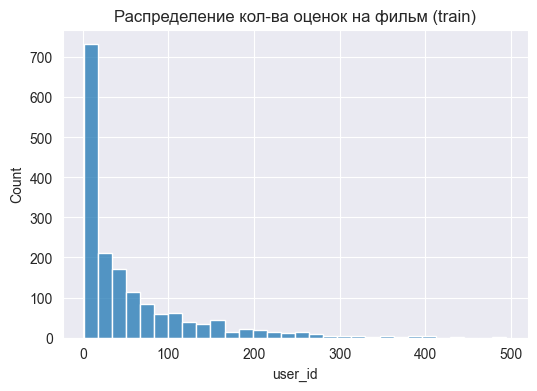

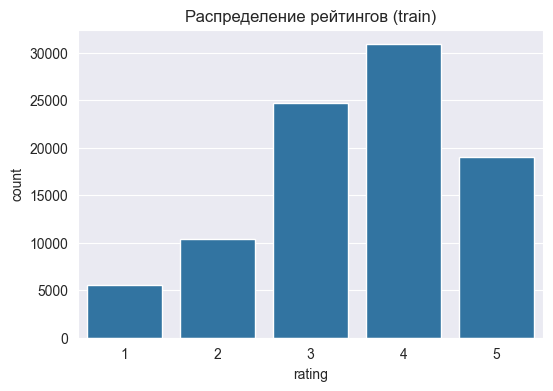

num_users: 943, num_items: 1680


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_path = 'ua.base'
test_path  = 'ua.test'
cols = ['user_id', 'item_id', 'rating', 'timestamp']

train_data = pd.read_csv(train_path, sep='\t', names=cols, header=None)
test_data  = pd.read_csv(test_path,  sep='\t', names=cols, header=None)

print("Train shape:", train_data.shape)
print("Test shape: ", test_data.shape)

n_users = train_data['user_id'].nunique()
n_items = train_data['item_id'].nunique()
print(f"Число уникальных пользователей (train): {n_users}")
print(f"Число уникальных фильмов (train): {n_items}")

# Гистограммы распределения
user_cnt = train_data.groupby('user_id')['item_id'].count()
item_cnt = train_data.groupby('item_id')['user_id'].count()

plt.figure(figsize=(6,4))
sns.histplot(user_cnt, bins=30, kde=False)
plt.title("Распределение кол-ва оценок на пользователя (train)")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(item_cnt, bins=30, kde=False)
plt.title("Распределение кол-ва оценок на фильм (train)")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='rating', data=train_data, order=sorted(train_data['rating'].unique()))
plt.title("Распределение рейтингов (train)")
plt.show()

# Переиндексация и сплит на train/val
unique_users = train_data['user_id'].unique()
unique_items = train_data['item_id'].unique()

user_to_idx = {u: i for i, u in enumerate(unique_users)}
item_to_idx = {m: i for i, m in enumerate(unique_items)}

train_data['user_idx'] = train_data['user_id'].map(user_to_idx)
train_data['item_idx'] = train_data['item_id'].map(item_to_idx)

# Убираем из test тех, кого нет в train
test_data = test_data[
    test_data['user_id'].isin(unique_users) &
    test_data['item_id'].isin(unique_items)
].copy()
test_data['user_idx'] = test_data['user_id'].map(user_to_idx)
test_data['item_idx'] = test_data['item_id'].map(item_to_idx)

num_users_train = len(unique_users)
num_items_train = len(unique_items)
print(f"num_users: {num_users_train}, num_items: {num_items_train}")

val_frac = 0.1
val_size = int(len(train_data) * val_frac)
val_df   = train_data.iloc[:val_size].copy()
train_df = train_data.iloc[val_size:].copy()

Сама модель
Мы используем матричную факторизацию с биасами (user/item bias) и латентными эмбеддингами (размерность n_factors обучаемую через mini-batch Adam (с гиперпараметрами lr, beta1, beta2, eps) и L2-регуляризацию (reg_emb, reg_bias). Для предотвращения переобучения вводим early stopping (отслеживая RMSE на валидации), а для подбора гиперпараметров (n_factors, lr, reg_emb) используем grid search по валидационному RMSE. После обучения вычисляем метрики Precision@k, Recall@k на тесте (с порогом релевантности), а также визуализируем обученные эмбеддинги пользователей и фильмов с помощью UMAP и t-SNE (четыре отдельные графика: UMAP-users, UMAP-items, t-SNE-users, t-SNE-items).

In [2]:
import math
from collections import defaultdict

class AdamOptimizer:
    def __init__(self, shape, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = np.zeros(shape, dtype=np.float32)
        self.v = np.zeros(shape, dtype=np.float32)
        self.t = 0

    def update(self, w, grad):
        self.t += 1
        self.m = self.beta1 * self.m + (1 - self.beta1) * grad
        self.v = self.beta2 * self.v + (1 - self.beta2) * (grad ** 2)
        m_hat = self.m / (1 - self.beta1 ** self.t)
        v_hat = self.v / (1 - self.beta2 ** self.t)
        w -= self.lr * m_hat / (np.sqrt(v_hat) + self.eps)

class MatrixFactorizationWithBiases:
    def __init__(
            self,
            num_users,
            num_items,
            n_factors=40,
            lr=0.005,
            beta1=0.9,
            beta2=0.999,
            eps=1e-8,
            reg_emb=0.02,
            reg_bias=0.01,
            n_epochs=30,
            batch_size=1024,
            early_stopping_patience=3,
            seed=42
    ):
        np.random.seed(seed)
        self.num_users = num_users
        self.num_items = num_items
        self.n_factors = n_factors
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.reg_emb = reg_emb
        self.reg_bias = reg_bias
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.early_stopping_patience = early_stopping_patience

        self.mu = 0.
        self.b_u = np.zeros(num_users, dtype=np.float32)
        self.b_i = np.zeros(num_items, dtype=np.float32)

        self.P = 0.01 * np.random.randn(num_users, n_factors).astype(np.float32)
        self.Q = 0.01 * np.random.randn(num_items, n_factors).astype(np.float32)

        # Adam для каждого массива
        self.opt_b_u = AdamOptimizer(self.b_u.shape, lr=self.lr, beta1=self.beta1, beta2=self.beta2, eps=self.eps)
        self.opt_b_i = AdamOptimizer(self.b_i.shape, lr=self.lr, beta1=self.beta1, beta2=self.beta2, eps=self.eps)
        self.opt_P   = AdamOptimizer(self.P.shape,   lr=self.lr, beta1=self.beta1, beta2=self.beta2, eps=self.eps)
        self.opt_Q   = AdamOptimizer(self.Q.shape,   lr=self.lr, beta1=self.beta1, beta2=self.beta2, eps=self.eps)

    def fit(self, df_train, df_val=None):
        # Глобальное среднее
        self.mu = df_train['rating'].mean()

        train_users   = df_train['user_idx'].values
        train_items   = df_train['item_idx'].values
        train_ratings = df_train['rating'].values.astype(np.float32)

        if df_val is not None:
            val_users   = df_val['user_idx'].values
            val_items   = df_val['item_idx'].values
            val_ratings = df_val['rating'].values.astype(np.float32)

        best_val_rmse = float('inf')
        no_improve_count = 0

        for epoch in range(self.n_epochs):
            perm = np.random.permutation(len(df_train))
            batch_start = 0
            while batch_start < len(df_train):
                batch_end = min(batch_start + self.batch_size, len(df_train))
                batch_idx = perm[batch_start:batch_end]

                bu = train_users[batch_idx]
                bi = train_items[batch_idx]
                r  = train_ratings[batch_idx]

                pred = (self.mu
                        + self.b_u[bu]
                        + self.b_i[bi]
                        + np.sum(self.P[bu] * self.Q[bi], axis=1))

                err = r - pred

                grad_b_u = -err + self.reg_bias * self.b_u[bu]
                grad_b_i = -err + self.reg_bias * self.b_i[bi]
                grad_P   = -(err[:, None] * self.Q[bi]) + self.reg_emb * self.P[bu]
                grad_Q   = -(err[:, None] * self.P[bu]) + self.reg_emb * self.Q[bi]

                # формируем полные вектора
                grad_b_u_full = np.zeros_like(self.b_u)
                np.add.at(grad_b_u_full, bu, grad_b_u)

                grad_b_i_full = np.zeros_like(self.b_i)
                np.add.at(grad_b_i_full, bi, grad_b_i)

                grad_P_full = np.zeros_like(self.P)
                for i, user_idx in enumerate(bu):
                    grad_P_full[user_idx] += grad_P[i]

                grad_Q_full = np.zeros_like(self.Q)
                for i, item_idx in enumerate(bi):
                    grad_Q_full[item_idx] += grad_Q[i]

                # Обновляем
                self.opt_b_u.update(self.b_u, grad_b_u_full)
                self.opt_b_i.update(self.b_i, grad_b_i_full)
                self.opt_P.update(self.P, grad_P_full)
                self.opt_Q.update(self.Q, grad_Q_full)

                batch_start = batch_end

            # Логируем RMSE
            train_rmse = self.evaluate_rmse(df_train)
            if df_val is not None:
                val_rmse = self.evaluate_rmse(df_val)
                print(f"Epoch {epoch+1}/{self.n_epochs}, "
                      f"Train RMSE={train_rmse:.4f}, Val RMSE={val_rmse:.4f}")

                if val_rmse < best_val_rmse - 1e-6:
                    best_val_rmse = val_rmse
                    no_improve_count = 0
                else:
                    no_improve_count += 1
                    if no_improve_count >= self.early_stopping_patience:
                        print("Early stopping triggered!")
                        break
            else:
                print(f"Epoch {epoch+1}/{self.n_epochs}, Train RMSE={train_rmse:.4f}")

    def evaluate_rmse(self, df):
        users = df['user_idx'].values
        items = df['item_idx'].values
        true_ratings = df['rating'].values
        preds = (self.mu
                 + self.b_u[users]
                 + self.b_i[items]
                 + np.sum(self.P[users] * self.Q[items], axis=1))
        mse = np.mean((true_ratings - preds) ** 2)
        return math.sqrt(mse)

    def predict(self, user_idx, item_idx):
        return float(self.mu
                     + self.b_u[user_idx]
                     + self.b_i[item_idx]
                     + np.dot(self.P[user_idx], self.Q[item_idx]))

    def recommend_for_user(self, user_idx, N=10):
        scores = (self.mu
                  + self.b_u[user_idx]
                  + self.b_i
                  + np.dot(self.P[user_idx], self.Q.T))
        return np.argsort(scores)[::-1][:N]

перебор гиперпараметров

In [ ]:
def run_experiment(params):
    """
    Обучаем модель с заданными params, возвращаем (val_rmse, model).
    """
    model = MatrixFactorizationWithBiases(
        num_users=num_users_train,
        num_items=num_items_train,
        n_factors=params['n_factors'],
        lr=params['lr'],
        reg_emb=params['reg_emb'],
        reg_bias=0.01,
        n_epochs=15,  # для примера
        batch_size=1024,
        early_stopping_patience=3,
        seed=42
    )
    model.fit(train_df, df_val=val_df)
    val_rmse = model.evaluate_rmse(val_df)
    return val_rmse, model

import itertools

param_grid = {
    'n_factors': range(20, 41, 2),
    'lr': np.arange(0.005, 0.011, 0.005),
    'reg_emb': np.arange(0.01, 0.06, 0.01)
}

best_val_rmse = float('inf')
best_params   = None
best_model    = None

for nf, lr, reg in itertools.product(param_grid['n_factors'],
                                     param_grid['lr'],
                                     param_grid['reg_emb']):
    params = {
        'n_factors': nf,
        'lr': lr,
        'reg_emb': reg
    }
    print(f"\n==== Testing: n_factors={nf}, lr={lr}, reg_emb={reg} ====")
    val_rmse, model_ = run_experiment(params)
    print(f"Result val RMSE = {val_rmse:.4f}")
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_params   = params
        best_model    = model_

print("\n===== Grid Search Complete =====")
print(f"Best val RMSE = {best_val_rmse:.4f}")
print("Best params:", best_params)


==== Testing: n_factors=20, lr=0.005, reg_emb=0.01 ====
Epoch 1/15, Train RMSE=0.9865, Val RMSE=1.0963
Epoch 2/15, Train RMSE=0.8768, Val RMSE=1.0812
Epoch 3/15, Train RMSE=0.8195, Val RMSE=1.0769
Epoch 4/15, Train RMSE=0.7740, Val RMSE=1.0750
Epoch 5/15, Train RMSE=0.7332, Val RMSE=1.0740
Epoch 6/15, Train RMSE=0.6976, Val RMSE=1.0732
Epoch 7/15, Train RMSE=0.6685, Val RMSE=1.0725
Epoch 8/15, Train RMSE=0.6460, Val RMSE=1.0719
Epoch 9/15, Train RMSE=0.6284, Val RMSE=1.0708
Epoch 10/15, Train RMSE=0.6149, Val RMSE=1.0703
Epoch 11/15, Train RMSE=0.6041, Val RMSE=1.0692
Epoch 12/15, Train RMSE=0.5950, Val RMSE=1.0686
Epoch 13/15, Train RMSE=0.5875, Val RMSE=1.0679
Epoch 14/15, Train RMSE=0.5811, Val RMSE=1.0669
Epoch 15/15, Train RMSE=0.5756, Val RMSE=1.0661
Result val RMSE = 1.0661

==== Testing: n_factors=20, lr=0.005, reg_emb=0.02 ====
Epoch 1/15, Train RMSE=0.9878, Val RMSE=1.0962
Epoch 2/15, Train RMSE=0.8817, Val RMSE=1.0804
Epoch 3/15, Train RMSE=0.8287, Val RMSE=1.0750
Epoch 4/1

In [ ]:
test_rmse = best_model.evaluate_rmse(test_data)
print(f"\n[Best Model] Test RMSE = {test_rmse:.4f}")

def precision_at_k(model, df_test, k=50, rating_threshold=4.0):
    user_positive_items = defaultdict(set)
    for row in df_test.itertuples():
        if row.rating >= rating_threshold:
            user_positive_items[row.user_idx].add(row.item_idx)
    precisions = []
    unique_users_test = df_test['user_idx'].unique()
    for u in unique_users_test:
        recs = model.recommend_for_user(u, N=k)
        hits = sum((itm in user_positive_items[u]) for itm in recs)
        prec_u = hits / k
        precisions.append(prec_u)
    return np.mean(precisions)

def recall_at_k(model, df_test, k=50, rating_threshold=3.5):
    user_positive_items = defaultdict(set)
    for row in df_test.itertuples():
        if row.rating >= rating_threshold:
            user_positive_items[row.user_idx].add(row.item_idx)
    recalls = []
    unique_users_test = df_test['user_idx'].unique()
    for u in unique_users_test:
        recs = model.recommend_for_user(u, N=k)
        relevant = user_positive_items[u]
        if len(relevant) == 0:
            continue
        hits = sum((itm in relevant) for itm in recs)
        recall = hits / len(relevant)
        recalls.append(recall)
    if len(recalls) == 0:
        return 0.0
    return np.mean(recalls)

p50  = precision_at_k(best_model, test_data, k=50,  rating_threshold=3.5)
p30 = precision_at_k(best_model, test_data, k=30, rating_threshold=3.5)
r50  = recall_at_k(best_model, test_data, k=50,  rating_threshold=3.5)
r30 = recall_at_k(best_model, test_data, k=30, rating_threshold=3.5)

print(f"Precision@50: {p50:.4f}")
print(f"Recall@50: {r50:.4f}")
print(f"Precision@30: {p30:.4f}")
print(f"Recall@30: {r30:.4f}")

Визуализация эмбеддингов для пользователей и фильмов

In [ ]:
import umap.umap_ as umap
from sklearn.manifold import TSNE

user_emb = best_model.P  # [num_users, n_factors]
item_emb = best_model.Q  # [num_items, n_factors]

# 1) UMAP для пользователей
umap_users = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
user_2d_umap = umap_users.fit_transform(user_emb)
print("user_2d_umap shape:", user_2d_umap.shape)

# 2) UMAP для фильмов
umap_items = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
item_2d_umap = umap_items.fit_transform(item_emb)
print("item_2d_umap shape:", item_2d_umap.shape)

# 3) t-SNE для пользователей
tsne_users = TSNE(n_components=2, perplexity=30, random_state=42)
user_2d_tsne = tsne_users.fit_transform(user_emb)
print("user_2d_tsne shape:", user_2d_tsne.shape)

# 4) t-SNE для фильмов
tsne_items = TSNE(n_components=2, perplexity=30, random_state=42)
item_2d_tsne = tsne_items.fit_transform(item_emb)
print("item_2d_tsne shape:", item_2d_tsne.shape)

#  Отрисовка UMAP Users 
plt.figure(figsize=(7, 6))
plt.scatter(user_2d_umap[:, 0], user_2d_umap[:, 1], c='blue', alpha=0.6)
plt.title("UMAP - User Embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

#  UMAP Items 
plt.figure(figsize=(7, 6))
plt.scatter(item_2d_umap[:, 0], item_2d_umap[:, 1], c='red', alpha=0.6)
plt.title("UMAP - Item Embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

#  t-SNE Users 
plt.figure(figsize=(7, 6))
plt.scatter(user_2d_tsne[:, 0], user_2d_tsne[:, 1], c='blue', alpha=0.6)
plt.title("t-SNE - User Embeddings")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.show()

#  t-SNE Items 
plt.figure(figsize=(7, 6))
plt.scatter(item_2d_tsne[:, 0], item_2d_tsne[:, 1], c='red', alpha=0.6)
plt.title("t-SNE - Item Embeddings")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.show()